In [1]:
import numpy as np
import astropy.constants as cons
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from tqdm import tqdm
from gala.potential import NFWPotential
from gala.units import galactic, solarsystem, dimensionless

import sys
sys.path.append('/sdf/home/j/jaymarie/software/gravitree/python')

## NFW profile testing

At a fixed radius (say $r=3 \mathrm{\, kpc}$), can I obtain the tidal tensor from an analytic expression of the NFW potential and gravitational acceleration?

$$T_{ij} = H_{ij} - \frac{1}{3} H_k^k \eta_{ij}$$

where $H_{ij} = \frac{\partial^2 \Phi}{\partial x^i \partial x^j}$.

If the profile is spherically symmetric, then all terms with $\partial_\phi, \, \partial_\theta$ are zero.

So the only non-zero component of $H_{ij}$ is $H_{rr} = \frac{\partial^2 \Phi}{\partial r^2}$.

We know that $\Phi_\mathrm{NFW} = - \frac{4\pi G \rho_0 R_s^3}{r} \ln \left(1 + \frac{r}{R_s}\right)$

and that the radial force is $F_r = - \nabla \Phi = - \partial_r \Phi$

$$\partial_r \Phi = -\frac{GM_\mathrm{vir}}{\ln(1+c) - c / (1+c)} \frac{r/(r+R_s) - \ln ( 1+ r/R_s)}{r^2}$$

overdensity radius relates mvir and rvir (redshift dep quant)

In [2]:
def getTidalTensor(r, mvir, Rs):    
    # setup tensor
    nfw_potential = NFWPotential(mvir * u.Msun, Rs*u.kpc, units=galactic)
    H_ij = nfw_potential.hessian([r, 0, 0]).reshape(3, 3).to(u.Gyr**(-2))
    # calculate the traceless part of the tensor
    tensor = (-(1/3)*np.trace(H_ij) * np.identity(3) + H_ij)
    return tensor

In [3]:
cvir = [11.141276,
 10.212291,
 9.853526,
 13.760278,
 15.731635,
 9.627233,
 13.285234,
 11.534417,
 11.872965,
 9.290159]

rvir = [25.50916,
 27.34847,
 28.241909,
 19.975464,
 17.903893,
 29.838192,
 21.226343,
 23.581104,
 23.41631,
 31.208279]

lams_r = []
oms_r = []
rts_r = []

radii = np.logspace(-1, 2, 30)
m = 2e5 * u.Msun

for i in np.arange(len(rvir)):
    lams = []
    oms = []
    rts = []
    for r_i in radii:
        tt = getTidalTensor(r_i, 1e12, rvir[i])
        
        lam = (np.max(np.abs(np.linalg.eig(tt)[0]))).to(1/u.Gyr**2).value
        om = ((lam / 3)**(1/2))
        rt = ((cons.G * m / (lam / u.Gyr**2))**(1/3)).to(u.kpc).value
        
        lams.append(lam)
        oms.append(om)
        rts.append(rt)
        
    lams_r.append(lams)
    oms_r.append(oms)
    rts_r.append(rts)
    
lams_r = np.array(lams_r)
oms_r = np.array(oms_r)
rts_r = np.array(rts_r)

In [4]:
rts_r[0]

array([0.03392484, 0.03672845, 0.03976386, 0.04305033, 0.04660876,
       0.05046189, 0.05463454, 0.05915392, 0.06405003, 0.06935631,
       0.07511047, 0.08135591, 0.08814366, 0.09553542, 0.10360795,
       0.11245933, 0.12221768, 0.13305266, 0.14519014, 0.15893002,
       0.17466687, 0.19291325, 0.21432562, 0.23973354, 0.27017383,
       0.30693231, 0.35159653, 0.40612362, 0.4729276 , 0.55499131])

10it [00:00, 170.64it/s]


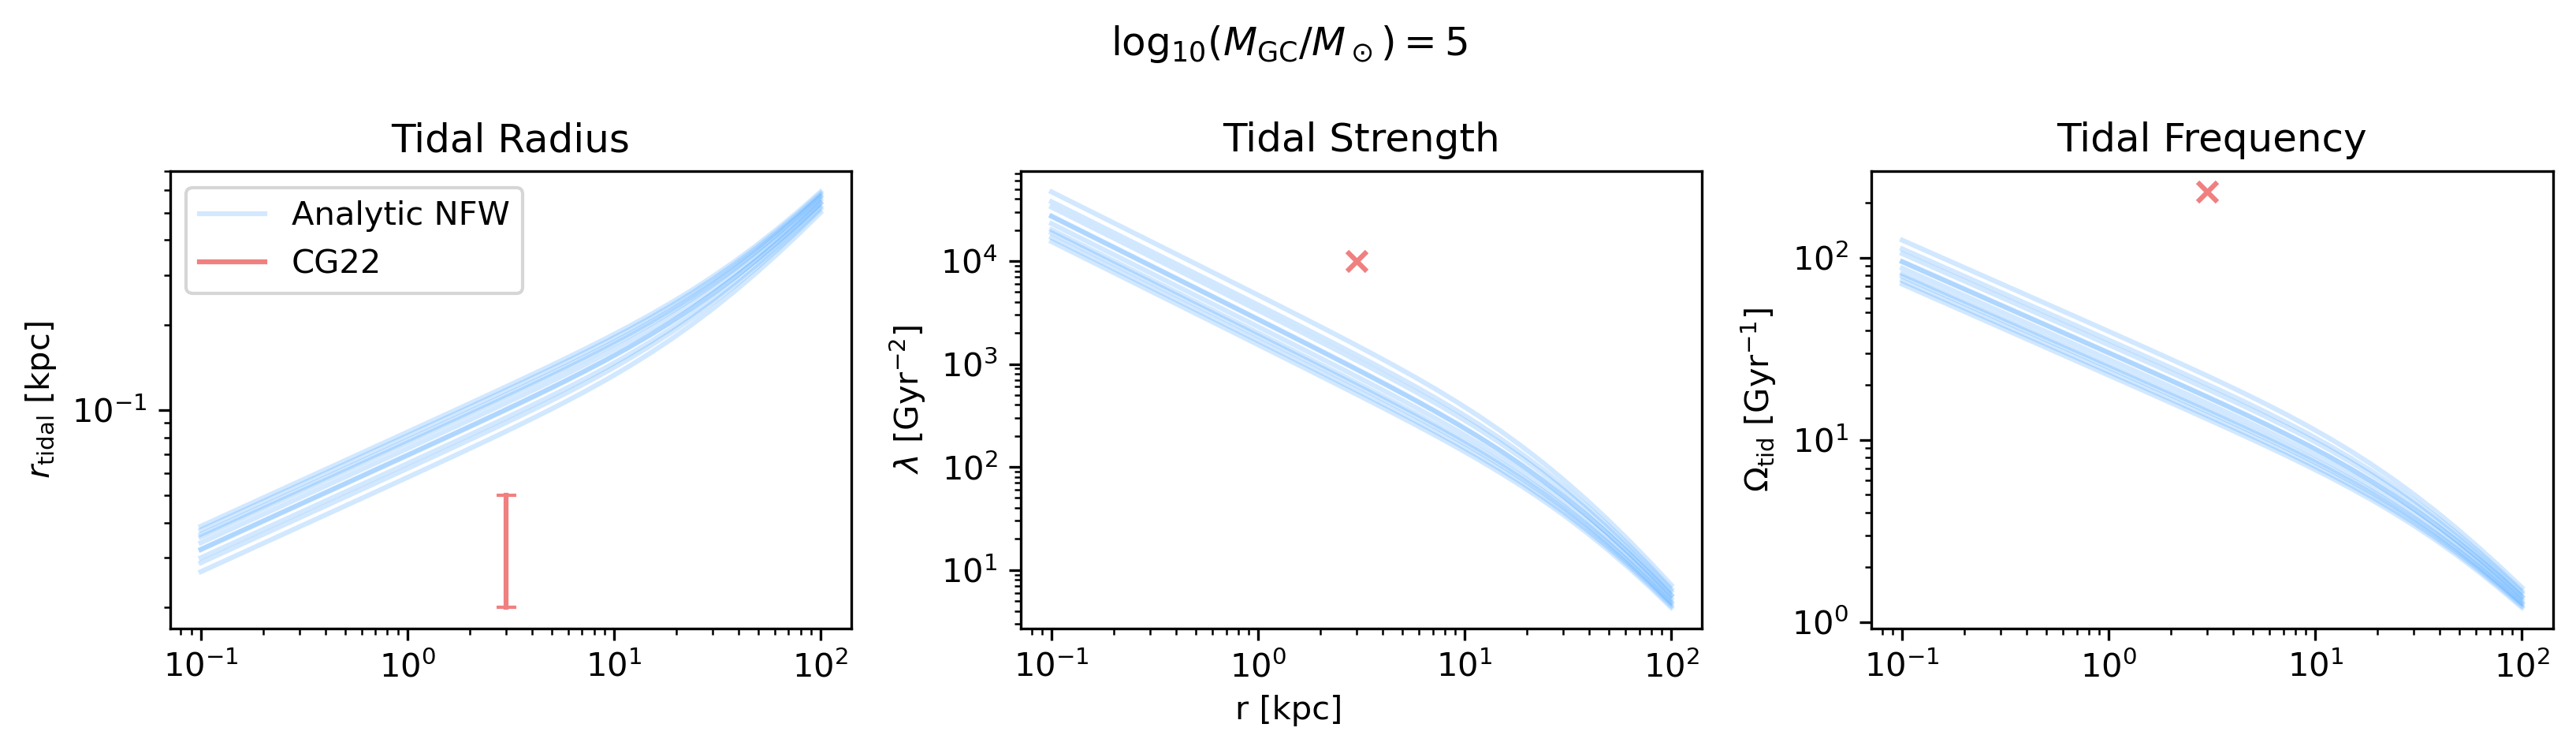

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(11,3), dpi=300)

ax[0].loglog([], [], c='dodgerblue', alpha=.2, label='Analytic NFW')

for r_t_mw, lam, om in tqdm(zip(rts_r, lams_r, oms_r)):
    ax[0].loglog(radii, r_t_mw, c='dodgerblue', alpha=.2)
    ax[1].loglog(radii, lam, c='dodgerblue', alpha=.2)
    ax[2].loglog(radii, om, c='dodgerblue', alpha=.2)

# ax[2].loglog(R_gal, 4*om, c='mediumseagreen', alpha=.5, ls='--')

ax[0].set_title('Tidal Radius')
ax[1].set_title('Tidal Strength')
ax[2].set_title('Tidal Frequency')

ax[0].set_ylabel(r'$r_\mathrm{tidal}$ [kpc]')
ax[1].set_ylabel(r'$\lambda$ [Gyr$^{-2}$]')
ax[2].set_ylabel(r'$\Omega_\mathrm{tid}$ [Gyr$^{-1}$]')

ax[0].plot([3, 3], [0.02, 0.05], marker='_', color='lightcoral', label='CG22')
ax[1].scatter(3, 1e4, marker='x', c='lightcoral', label='CG22')
ax[2].scatter(3, 230, marker='x', c='lightcoral', label='CG22')

ax[0].legend()

fig.suptitle(r'$\log_{10} (M_\mathrm{GC} / M_\odot) = 5$')

fig.text(0.5, 0, 'r [kpc]', ha='center')

# mass_loss = 

fig.tight_layout()
plt.show()


In [6]:
# Hessian change of basis

def sphericalToCartesianTensor(r, theta, phi):
    t_11 = np.sin(theta) * np.cos(phi)
    t_12 = r * np.cos(theta) * np.cos(phi)
    t_13 = -r * np.sin(theta) * np.sin(phi)
    
    t_21 = np.sin(theta) * np.sin(phi)
    t_22 = r * np.cos(theta) * np.sin(phi)
    t_23 = r * np.sin(theta) * np.cos(phi)
    
    t_31 = np.cos(theta)
    t_32 = -r * np.sin(theta)
    t_33 = 0
    
    tensor = np.array(
        [
            [t_11, t_12, t_13],
            [t_21, t_22, t_23],
            [t_31, t_32, t_33]
        ]
    )
    
    return tensor

In [21]:
q_x = 1
q_y = 1
q_z = 1

r = (q_x**2 + q_y**2 + q_z**2)**(1/2)
theta = np.arccos(q_z / r)
phi = np.sign(q_y) * np.arccos(q_x / np.sqrt(q_x**2 + q_y**2))

In [22]:
nfw_pot = NFWPotential(1e12 * u.Msun, 25*u.kpc, units=galactic)
H_ij = nfw_pot.hessian([q_x, q_y, q_z]).reshape(3, 3).to(u.Gyr**(-2))
tensor = (-(1/3)*np.trace(H_ij) * np.identity(3) + H_ij)

In [23]:
T = sphericalToCartesianTensor(r, theta, phi)
T_inv = np.linalg.inv(T)

In [24]:
np.isclose(np.max(np.abs(np.linalg.eig(T @ (tensor @ T_inv))[0])), np.max(np.abs(np.linalg.eig(tensor)[0])))

True

In [25]:
np.max(np.abs(np.linalg.eig(T @ (tensor @ T_inv))[0]))

<Quantity 1376.53455903 1 / Gyr2>

In [26]:

class NFW():
    """
    This is a Profile class for an NFW profile
    """
    
    def __init__(self, mvir, rvir, conc):
        
        self.type = "nfw"
        
        # set up parameters
        self.mvir = mvir
        self.rvir = rvir
        self.conc = conc
        
        # calculate aux params
        
        self.Rs = self.rvir / self.conc
        
        # units of density is Msun/kpc3
        self.rho0 = (
            self.mvir * u.Msun / \
            (4 * np.pi * (self.Rs * u.kpc)**3 * \
             (np.log(1+self.conc) - (self.conc/(1+self.conc))))).value

    def hessian(self, r, phi=0., theta=0.):
        
        H_rr = 4 * np.pi * c.G * self.rho0 * (self.Rs * u.kpc)**3 * (u.Msun / u.kpc**3) * (r*(3*r + 2 * (self.Rs * u.kpc)) - 2. * (r + (self.Rs * u.kpc))**2 * np.log(((r + (self.Rs * u.kpc))/(self.Rs * u.kpc)).value)) / (r**3 * (r + (self.Rs * u.kpc))**2)        
        H_rr = H_rr.to(u.Gyr**(-2)).value
        H_ij = np.diag(np.array([H_rr, 0, 0]))
        return H_ij


In [27]:
nfw_hm = NFW(1e12, 25, 10)

In [33]:
metric = np.diag(np.array([1, r**2, (r*np.sin(theta))**2]))

hess = T @ (nfw_hm.hessian(r * u.kpc) @ T_inv)
tt_hm = hess - (1/3)*np.trace(hess) * np.identity(1)

In [34]:
np.max(np.abs(np.linalg.eig(tt_hm)[0]))

5.4569682106375694e-12

In [32]:
tt_hm

array([[ 3.63797881e-12,  0.00000000e+00, -1.81898940e-12],
       [ 0.00000000e+00, -1.81898940e-12, -3.63797881e-12],
       [ 0.00000000e+00, -1.81898940e-12, -3.63797881e-12]])

In [31]:
tensor.value

array([[ 2.27373675e-13, -6.88267280e+02, -6.88267280e+02],
       [-6.88267280e+02,  2.27373675e-13, -6.88267280e+02],
       [-6.88267280e+02, -6.88267280e+02,  2.27373675e-13]])